# 117th US Congress Twitter Network

## 1. Load Dependencies

In this section, we import all necessary Python libraries used throughout the analysis.

These include tools for:

- Working with JSON data  
- Performing network analysis with **NetworkX**  
- Manipulating tabular data using **pandas**  
- Visualizing results with **matplotlib**

These libraries form the foundation for the congressional co-sponsorship network analysis.


In [4]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Dataset

We load the dataset files that contain information about congressional members and their co-sponsorship relationships.

The files used in this project can be found linked in the repository’s project report.

The goal of this step is to parse the raw data and prepare it for graph construction.


In [10]:
# You can find the files to download in the project report of the repository
with open(r"your_path/congress_network_data.json", "r") as f:
    data = json.load(f)[0]

# Extract lists
inList = data["inList"]
inWeight = data["inWeight"]
outList = data["outList"]
outWeight = data["outWeight"]
usernameList = data["usernameList"]

# --- Create a directed graph ---
G = nx.DiGraph()

# Add nodes with username attributes
for i, username in enumerate(usernameList):
    G.add_node(i, username=username)

# Add weighted directed edges using outList (from → to)
for src, (targets, weights) in enumerate(zip(outList, outWeight)):
    for dst, w in zip(targets, weights):
        G.add_edge(src, dst, weight=w)

# --- Example: print some info ---
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Example: print a few edges with weights
for u, v, d in list(G.edges(data=True))[:30]:
    print(f"{G.nodes[u]['username']} -> {G.nodes[v]['username']} (weight={d['weight']})")

Number of nodes: 475
Number of edges: 13289
SenatorBaldwin -> SenBlumenthal (weight=0.002105263157894737)
SenatorBaldwin -> SenatorCardin (weight=0.002105263157894737)
SenatorBaldwin -> SenCortezMasto (weight=0.002105263157894737)
SenatorBaldwin -> SenatorDurbin (weight=0.004210526315789474)
SenatorBaldwin -> LindseyGrahamSC (weight=0.002105263157894737)
SenatorBaldwin -> SenAmyKlobuchar (weight=0.00631578947368421)
SenatorBaldwin -> SenJeffMerkley (weight=0.002105263157894737)
SenatorBaldwin -> ChrisMurphyCT (weight=0.002105263157894737)
SenatorBaldwin -> PattyMurray (weight=0.004210526315789474)
SenatorBaldwin -> SenatorShaheen (weight=0.002105263157894737)
SenatorBaldwin -> SenTinaSmith (weight=0.004210526315789474)
SenatorBaldwin -> SenStabenow (weight=0.002105263157894737)
SenatorBaldwin -> MarkWarner (weight=0.002105263157894737)
SenatorBaldwin -> SenatorWarnock (weight=0.002105263157894737)
SenatorBaldwin -> SenWarren (weight=0.00631578947368421)
SenatorBaldwin -> RepJudyChu (we

## 3. Strong Connectivity Check

We verify whether the directed network is **strongly connected**, meaning:

> Every node is reachable from every other node through directed paths.

This property is important when applying algorithms like PageRank or centrality measures that assume global reachability.

In [12]:
if nx.is_strongly_connected(G):
    d = nx.diameter(G)
else:
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc)
    d = nx.diameter(G_sub)

print("Diameter of largest strongly connected component:", d)

Diameter of largest strongly connected component: 6


## 4. Compute Network Density

Network density measures the proportion of actual edges compared to the maximum possible edges.

A higher density indicates a more interconnected congressional co-sponsorship network.

This metric provides a high-level sense of collaboration levels.


In [14]:
nx.density(G)

0.05902287363979569

## 5. Weighted Clustering Coefficient

We compute the **average weighted clustering coefficient** of the graph.

This metric evaluates how often a member of Congress's collaborators also collaborate with each other.

Using edge weights incorporates the **strength** or **frequency** of co-sponsorship relationships.

A higher value indicates a more tightly-knit collaboration structure.


In [16]:
avg_clustering_weighted = nx.average_clustering(G, weight='weight')
print("Average clustering (weighted):", avg_clustering_weighted)

Average clustering (weighted): 0.00880491261434575


In [18]:
if nx.is_strongly_connected(G):
    avg_spl = nx.average_shortest_path_length(G, weight='weight')
else:
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc)
    avg_spl = nx.average_shortest_path_length(G_sub, weight='weight')

print("Average shortest path length (weighted, largest SCC):", avg_spl)

Average shortest path length (weighted, largest SCC): 0.0063906996410342904


## 6. PageRank Computation

We compute **PageRank**, a widely used centrality measure that identifies influential legislators.

Interpretation:

- A node has high PageRank if it receives many edges  
- Or if it receives edges from other important nodes  

In the context of Congress:

> Members with high PageRank are influential co-sponsors who are central in legislative collaboration.


In [22]:
# PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85, weight='weight')

# Betweenness Centrality
betweenness_scores = nx.betweenness_centrality(G, weight='weight', seed=42)

# HITS algorithm
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)


data = {}
for node in G.nodes():
    node_attrs = G.nodes[node]
    username = node_attrs.get('username', f"user_{node}")  # fallback if missing
    data[node] = {
        "username": username,
        "pagerank": pagerank_scores.get(node, 0),
        "betweenness": betweenness_scores.get(node, 0),
        "hub": hubs.get(node, 0),
        "authority": authorities.get(node, 0)
    }

df = pd.DataFrame.from_dict(data, orient='index')
df = df.sort_values(by="pagerank", ascending=False)
df.head()

,username,pagerank,betweenness,hub,authority
322,GOPLeader,0.016696,0.070677,0.011312,0.039029
147,RepCasten,0.012845,0.049959,0.000374,0.002795
389,RepChipRoy,0.011028,0.037404,0.004206,0.032205
269,RepMikeJohnson,0.010660,0.009661,0.005424,0.024478
215,RepChuyGarcia,0.010580,0.037622,0.000601,0.002055


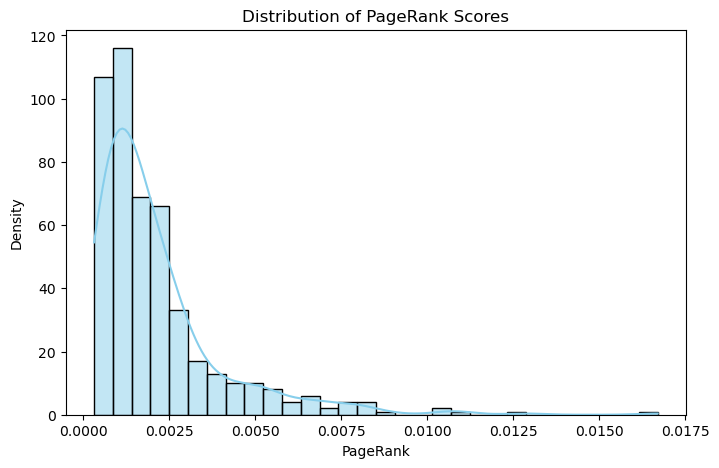

Percentage of pagerank scores below 0.001%: 29.4737%


,username,pagerank,betweenness,hub,authority
322,GOPLeader,0.016696,0.070677,0.011312,0.039029
147,RepCasten,0.012845,0.049959,0.000374,0.002795
389,RepChipRoy,0.011028,0.037404,0.004206,0.032205
269,RepMikeJohnson,0.010660,0.009661,0.005424,0.024478
215,RepChuyGarcia,0.010580,0.037622,0.000601,0.002055
208,RepFranklin,0.008885,0.000049,0.010146,0.016625
92,RepAdams,0.008246,0.020018,0.000634,0.003839
246,CongressmanHice,0.008157,0.005239,0.006279,0.017437
303,RepAndyLevin,0.008033,0.043764,0.000432,0.002331
113,RepAndyBiggsAZ,0.008026,0.039888,0.008104,0.019645


In [24]:
df_sorted = df.sort_values(by='pagerank', ascending=False)

plt.figure(figsize=(8,5))
sns.histplot(df['pagerank'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of PageRank Scores')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

count_below = (df['pagerank'] < 0.001).sum()

# Total number of nodes
total = len(df['pagerank'])
percentage = (count_below / total) * 100
print(f"Percentage of pagerank scores below 0.001%: {percentage:.4f}%")

df_sorted.head(12)

# 7. Additional Network Metric Visualization

We generate a more plots showcasing other properties of the network.

This visualization provides deeper insight into structural patterns within the congressional collaboration network.

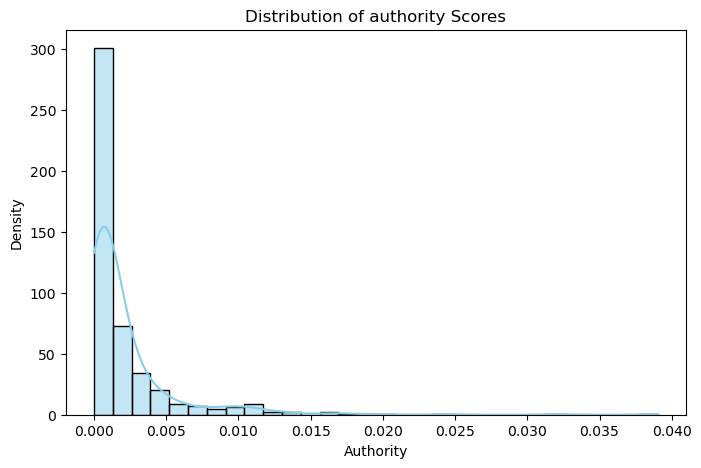

,username,pagerank,betweenness,hub,authority
322,GOPLeader,0.016696,0.070677,0.011312,3.902887e-02
389,RepChipRoy,0.011028,0.037404,0.004206,3.220461e-02
269,RepMikeJohnson,0.010660,0.009661,0.005424,2.447802e-02
113,RepAndyBiggsAZ,0.008026,0.039888,0.008104,1.964493e-02
246,CongressmanHice,0.008157,0.005239,0.006279,1.743737e-02
...,...,...,...,...,...
434,RepTomSuozzi,0.000316,0.000000,0.000148,-3.157896e-19
227,Lancegooden,0.000316,0.000000,0.001306,-3.516939e-19
356,RepOHalleran,0.000316,0.000000,0.000286,-4.248258e-19
456,RepAnnWagner,0.000316,0.000000,0.004354,-5.251954e-19


In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['authority'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of authority Scores')
plt.xlabel('Authority')
plt.ylabel('Density')
plt.show()

df_sorted = df.sort_values(by='authority', ascending=False)
df_sorted

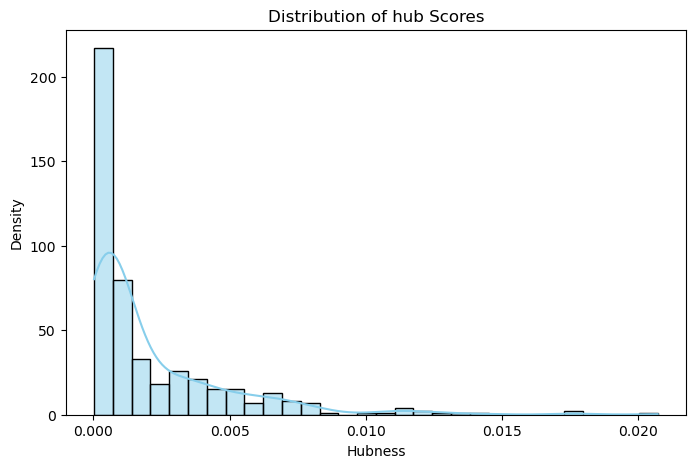

,username,pagerank,betweenness,hub,authority
226,RepBobGood,0.000975,0.000000,0.020715,0.000926
159,RepCloudTX,0.001049,0.000000,0.017802,0.003543
399,SteveScalise,0.004930,0.000616,0.017448,0.010878
164,RepJamesComer,0.001110,0.000000,0.014486,0.001450
129,VernBuchanan,0.001635,0.000000,0.013216,0.004252
...,...,...,...,...,...
437,claudiatenney,0.002247,0.007756,0.000061,0.002334
280,RepDanKildee,0.000372,0.000000,0.000056,0.000057
48,SenatorLeahy,0.000931,0.000361,0.000056,0.000444
187,RepLloydDoggett,0.000494,0.000937,0.000047,0.000496


In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['hub'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of hub Scores')
plt.xlabel('Hubness')
plt.ylabel('Density')
plt.show()

df_sorted = df.sort_values(by='hub', ascending=False)
df_sorted